## **Object detection ด้วย FastAI**

Object detection การสร้างโมเดลมาเพื่อทำนายบริเวณที่มีวัตถุที่สนใจ และหลังจากนั้นทำนายว่าวัตถุในบริเวณที่สนใจเป็นวัตถุประเภทใด

ในตัวอย่างนี้เราจะนำชุดข้อมูลจาก Kaggle competition: Global Wheat Detection (https://www.kaggle.com/competitions/global-wheat-detection/overview) มาตรวจจับและแยกประเภทของข้าวสาลีกัน

ใน Notebook นี้เราจะทำการ
- โหลดชุดข้อมูล
- สร้างไฟล์ Object detection ในรูปแบบของ COCO format
- รัน Object detection ด้วย FastAI

In [52]:
!kaggle datasets download -d tarunbisht11/yolo-animal-detection-small

 99%|█████████████████████████████████████▌| 30.0M/30.4M [00:05<00:00, 8.48MB/s]
100%|██████████████████████████████████████| 30.4M/30.4M [00:05<00:00, 5.51MB/s]


In [ ]:
!unzip yolo-animal-detection-small.zip -d yolo-animal-small

In [ ]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0

## **สร้าง COCO Dataset จากชุดข้อมูล CSV**

In [1]:
import json
import ast
import pandas as pd
import os.path as op
from pathlib import Path

In [55]:
annotation_df = pd.read_csv("yolo-animal-small/train.csv")
annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316


In [67]:
annotation_df["bbox"] = annotation_df.apply(
    lambda r: [r["xmin"], r["ymin"], r["xmax"] - r["xmin"], r["ymax"] - r["ymin"]],
    axis=1
)
annotation_df["area"] = annotation_df.apply(lambda r: r["bbox"][2] * r["bbox"][3], axis=1)
annotation_df["id"] = annotation_df.filename.map(lambda x: Path(x).stem)

In [68]:
annotation_df.head()

,filename,width,height,class,xmin,...,xmax,ymax,bbox,area,id
0,cats_001.jpg,474,266,cat,132,...,347,264,"[132, 1, 215, 263]",56545,cats_001
1,cats_002.jpg,474,474,cat,176,...,467,433,"[176, 44, 291, 389]",113199,cats_002
2,cats_003.jpg,474,314,cat,53,...,397,314,"[53, 1, 344, 313]",107672,cats_003
3,cats_004.jpg,474,355,cat,1,...,393,335,"[1, 1, 392, 334]",130928,cats_004
4,cats_005.jpg,474,316,cat,80,...,407,316,"[80, 1, 327, 315]",103005,cats_005


In [70]:
img_df = annotation_df.groupby("id").first().reset_index()[["id", "width", "height"]]
img_df["file_name"] = img_df.id.map(lambda p: op.join("yolo-animal-small/yolo-animal-detection-small/train/", f"{p}.jpg"))

In [71]:
img_df.head()

,id,width,height,file_name
0,cats_001,474,266,yolo-animal-small/yolo-animal-detection-small/train/cats_001.jpg
1,cats_002,474,474,yolo-animal-small/yolo-animal-detection-small/train/cats_002.jpg
2,cats_003,474,314,yolo-animal-small/yolo-animal-detection-small/train/cats_003.jpg
3,cats_004,474,355,yolo-animal-small/yolo-animal-detection-small/train/cats_004.jpg
4,cats_005,474,316,yolo-animal-small/yolo-animal-detection-small/train/cats_005.jpg


In [74]:
images = img_df.to_dict("records")

categories = []
for i, c in enumerate(annotation_df["class"].unique()):
    categories.append({"supercategory": "animal", "id": i, "name": c})
cat2idx = {r["name"]: r["id"] for r in categories}

In [76]:
annotation_df["category_id"] = annotation_df["class"].map(cat2idx)

In [77]:
annotation_df.rename(columns={"id": "image_id"}, inplace=True)

In [78]:
annotation_df["id"] = list(range(len(annotation_df)))
annotation_df["iscrowd"] = 0

In [79]:
annotations = annotation_df[["id", "category_id", "iscrowd", "bbox", "image_id", "area"]].to_dict("records")

In [80]:
coco_format = {
    "info": {"description": "Global Wheat Dataset, Kaggle", "url": "https://www.kaggle.com/competitions/global-wheat-detection/data"},
    "licenses": [
        {"url": "https://www.kaggle.com/competitions/global-wheat-detection/data"}
    ],
    "images": images,
    "annotations": annotations,
    "categories": categories
}

In [81]:
json.dump(coco_format, open("yolo-animal-small/coco_format.json", "w"), indent=2)

## **FastAI for Object detection**

Description: https://walkwithfastai.com/Object_Detection
Reference: https://youtu.be/5bSVug1YB3s?t=2067

In [87]:
from fastbook import *
from fastai.vision.all import *

# add path ไปยัง Github ที่ clone มา
import sys
sys.path.append('Practical-Deep-Learning-for-Coders-2.0/Computer Vision/')
from imports import *

In [88]:
# คำสั่งของ FastAI เพื่อได้ภาพ และ label boxes สำหรับแต่ละภาพ
imgs, label_bbox = get_annotations("yolo-animal-small/coco_format.json")
img2bbox = dict(zip(imgs, label_bbox))

In [89]:
# place holder สำหรับ get_items
def get_train_images(noop):
    return imgs

In [90]:
funcs = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

wheat_datablock = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_items=get_train_images,
    getters=funcs,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    n_inp=1
)

In [91]:
dls = wheat_datablock.dataloaders("globalwheat/train/")
dls.c = 7

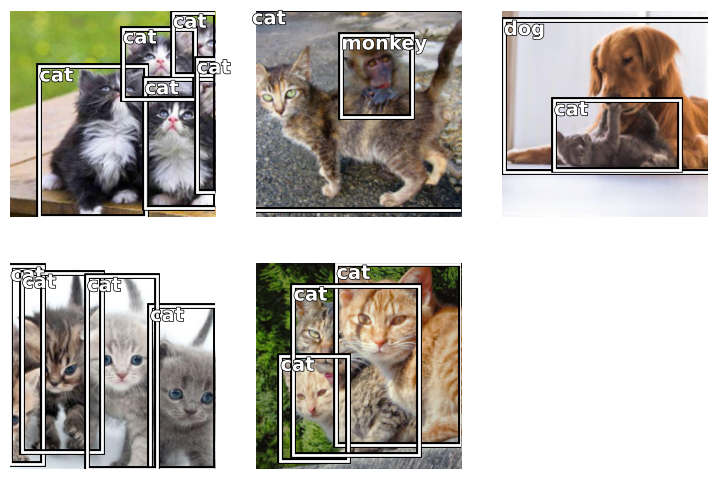

In [92]:
dls.show_batch(max_n=5)

In [93]:
encoder = create_body(resnet34, pretrained=True)

In [94]:
get_c(dls) # นับจำนวน Class

7

In [95]:
# สร้าง RetinaNet ด้วย Resnet34 encoder 
retina_net = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [96]:
retina_net.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [97]:
criterion = RetinaNetFocalLoss(scales=[1, 2**(-1/3), 2**(-2/3)], ratios=[1/2, 1, 2])

In [98]:
def _retinanet_split(m):
    return L(
        m.encoder,
        nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)
    ).map(params)

In [99]:
learner = Learner(dls, retina_net, loss_func=criterion, splitter=_retinanet_split)

In [100]:
learner.freeze()

In [101]:
# มี error จาก FastAI
# ref: https://forums.fast.ai/t/typeerror-no-implementation-found-for-torch-nn-functional-smooth-l1-loss-on-types-that-implement-torch-function-class-fastai-torch-core-tensorimage-class-fastai-vision-core-tensorbbox/90897
# ที่สามารถแก้ได้ด้วยบรรทัดต่อไปนี้
TensorImage.register_func(torch.nn.functional.smooth_l1_loss, TensorImage, TensorBBox)
TensorMultiCategory.register_func(TensorMultiCategory.mul, TensorMultiCategory, TensorImage)
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits, TensorImage, TensorMultiCategory)

In [102]:
learner.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.614878,3.538268,00:05
1,3.460555,2.779101,00:05
2,2.955453,1.419611,00:05
3,2.523819,1.225454,00:05
4,2.243980,1.284347,00:05
5,2.038003,1.175561,00:05
6,1.880247,1.146272,00:05
7,1.758402,1.123832,00:05
8,1.661773,1.121539,00:05
9,1.587168,1.118492,00:05


## **Object detection ด้วย IceVision**

ใน Section นี้เราจะใช้ไลบรารี่ Icevision ในการสร้างโมเดล Object detection กัน

In [ ]:
!export LD_LIBRARY_PATH=/usr/local/cuda-11.3/lib64

In [4]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/tupleteam/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [5]:
df = pd.read_csv("yolo-animal-small/train.csv")
df.rename(columns={"class": "label"}, inplace=True)

In [6]:
df.to_csv("yolo-animal-small/train_annotation.csv", index=False)

In [7]:
df.head()

,filename,width,height,label,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316


In [8]:
template_record = ObjectDetectionRecord()

class YoloSmallDataset(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
        self.df = pd.read_csv("yolo-animal-small/train_annotation.csv")
        self.class_map = ClassMap(list(self.df['label'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(op.join("yolo-animal-small/yolo-animal-detection-small/", "train", o.filename))
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

In [9]:
parser = YoloSmallDataset(template_record)
train_records, valid_records = parser.parse()

  0%|          | 0/1309 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/469 [00:00<?, ?it/s]

In [10]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x

In [11]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=224, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(224), tfms.A.Normalize()])

In [12]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [13]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=False)

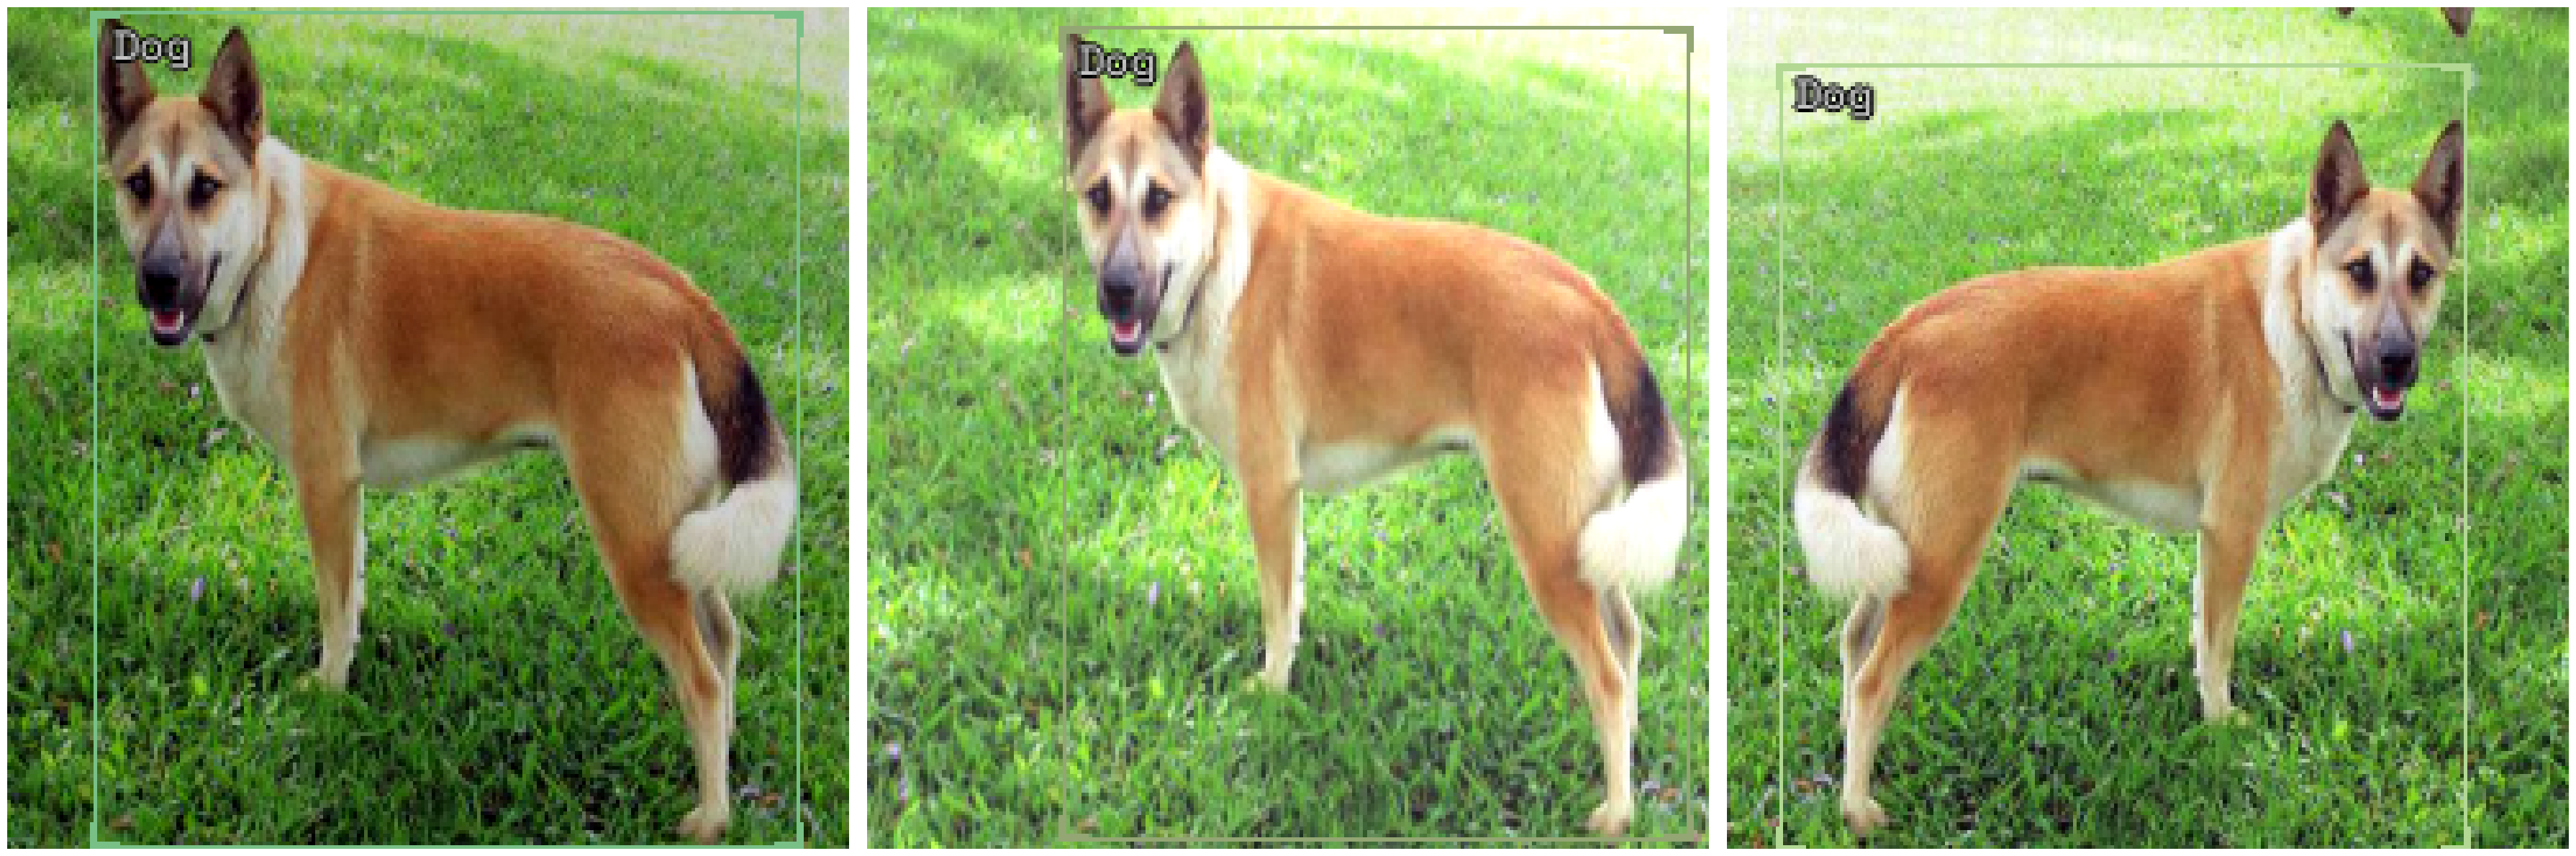

In [14]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map))

In [16]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/home/tupleteam/.local/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/tupleteam/.local/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(valley=6.30957365501672e-05)

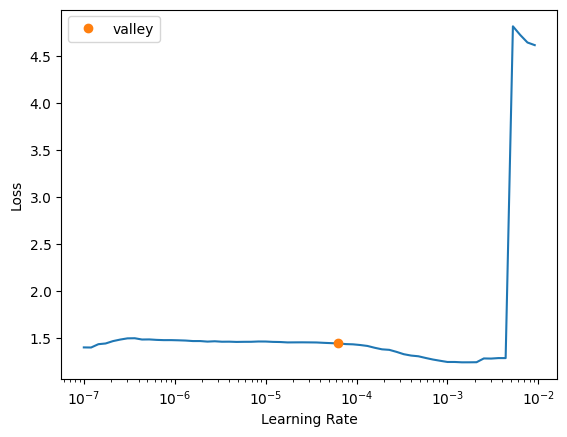

In [17]:
learner.lr_find()

In [25]:
learner.fine_tune(20, 6e-5, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.225668,0.241547,0.674819,00:08


epoch,train_loss,valid_loss,COCOMetric,time
0,0.223569,0.227994,0.690685,00:08
1,0.221702,0.216395,0.693912,00:07
2,0.227357,0.221256,0.696970,00:08
3,0.231106,0.226176,0.684636,00:08
4,0.229935,0.242172,0.663879,00:08
5,0.226743,0.231064,0.681058,00:07
6,0.221905,0.227383,0.683054,00:08
7,0.231685,0.228219,0.684466,00:08
8,0.225658,0.225340,0.683660,00:08
9,0.216813,0.216631,0.698541,00:08


In [39]:
from icevision.models import *

In [51]:
m = ClassMap(list(df['label'].unique()))
m.get_classes()

In [59]:
# เซฟโมเดลด้วยคำสั่ง `save_icevision_checkpoint`
checkpoint_path = "monkeycatdog_det.pth"
save_icevision_checkpoint(
    model, 
    model_name='mmdet.retinanet', 
    backbone_name='resnet50_fpn_1x',
    classes=m.get_classes(),
    img_size=224,
    filename=checkpoint_path,
    meta={"icevision_version": "0.12.0"}
)

## **Example prediction**

ลองใช้โมเดลทำนายผลใน validation dataset `valid_ds`

In [ ]:
# โหลดโมเดลที่เซฟมาเพื่อทำนายผลใน validation set
model_loaded = model_from_checkpoint("monkeycatdog_det.pth")

In [67]:
model_type = model_loaded["model_type"]
backbone = model_loaded["backbone"]
class_map = model_loaded["class_map"]
img_size = model_loaded["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.retinanet' from '/home/tupleteam/.local/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 <ClassMap: {'background': 0, 'cat': 1, 'monkey': 2, 'dog': 3}>,
 224)

/home/tupleteam/.local/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/tupleteam/.local/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


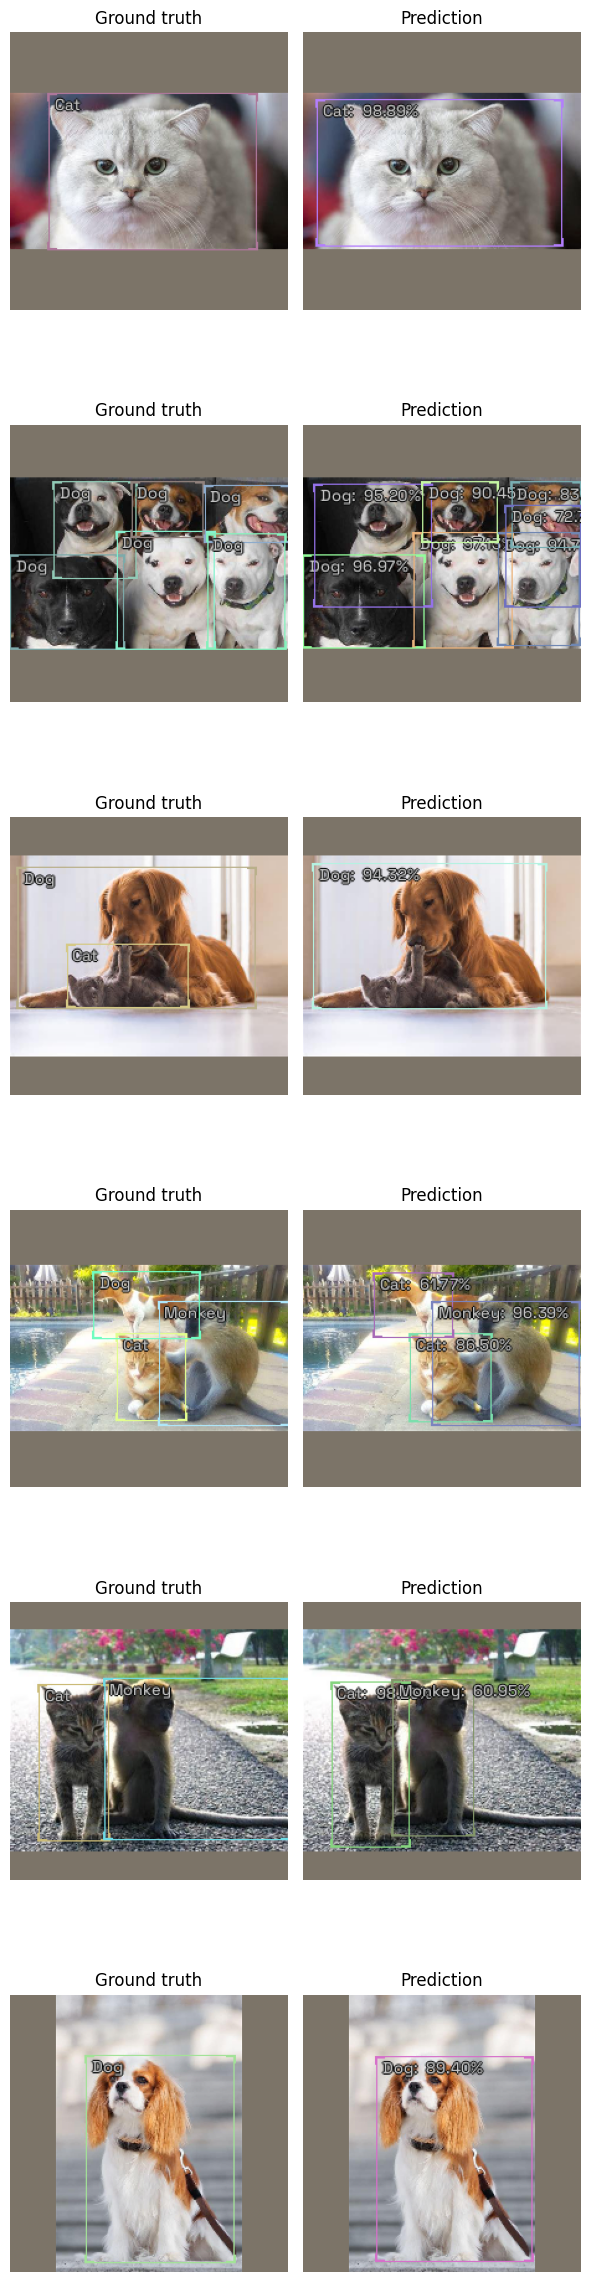

In [68]:
model_type.show_results(model_loaded["model"], valid_ds, detection_threshold=0.6)